This Notebook is Prepared by Samriddh Lakhmani : 
* Phone number : +91-9830052500
* Email id : samriddhlakhmani@gmail.com
* Linked-In : <a href='https://www.linkedin.com/in/samriddh-lakhmani/'> Click Here</a>
* Link to Resume : <a href='https://drive.google.com/file/d/1FkWkY74zbWmLKNaEhoC2sMxECrlB17C9/view?usp=sharing'>Click Here</a>
* My other work : <a href='https://github.com/samlakhmani'>Click Here</a>

# Introduction

This notebook will flow in the order of the models I made, so as to give a clearer picture of the though process. 

PS : I had a ensemble model of (SARIMAX + (liear regression of feature_2 based on feature_1)). That I have not added to the notebook as it was exploratory. But it gives a notion as to where this notebooks starts from. 

What I observed from plottig the data was that it was showing logarithmic tendencies. But since it has had a time association with the reading, I was decided to begin with time series analysis. 

PS : the EDA, Stationarity & SARIMAX was copy pasted from __Marco Peixeiro's__ Medium article on Stock data. Refrenced Below 

the ARIMAX model I developed editing the SARIMAX code. Moreover, Decomposition was added, which he ignored.

Only the code was taken to simple the process and reduce debugging time period and quickly itereate through parameters. I have given explanations as to my paramter selection throught the notebook.

Now coming to the Scores I got from the different models. And summing up my entire thought process in a gist here, before we dive into the notbook. 

RMSE Score on public data uploaded by the competition host : Model Desription

__ALL MODEL SCORES__

* __1154.30073__ : ensemble of SARIMAX + LR of feature_1 and feature_2 (I shall upload them on github, I dont mean to crowd this notebook!)
* __1412.25521__ : Polynomial Regression : Linear Regression on feature_1 and feature_2, by polynimial transformation of the order 3.
* __1602.09697__ : Only SARIMAX (AIC score of 4000s)
* I dont submit ARIMA for public data estimation due to limitations challenge. I had last try before intial deadline. (AIC score of 6000s as seen in this notebook)
* __596.78058__  : Using the mean of the last 10 data points as a perdiction for the next data point. 

Then I got inspired by the best score on the Leaderboard by Saurabh, who had used fbprohet, I choose to develop the model myself to check. Since the initial deadline was over, and I wanted to develop my skill on time-series:

* __926.39330__  : using fbprohet. 

Reason to go for Logrithmic transformation is given in the notebook

* __225.78494__ : Logarithmic transformation
* __243.19927__ : Logarithmic transformation and RandomForrest Regressor on the difference/remaining
* __475.38877__ : Logarithmic transformation and Sinusoidal on the difference/remaining

# 1. Lets Begin 

## Cleaning data 

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/into-the-future/train.csv
/kaggle/input/into-the-future/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from tqdm import tqdm_notebook

from itertools import product

In [3]:
#for kaggle
DATAPATH = '/kaggle/input/into-the-future/train.csv' 
#for my jupyter lab
# DATAPATH = 'Data/train.csv' 

In [4]:
data = pd.read_csv(DATAPATH, index_col=['time'], parse_dates=['time'])
data.head(10)

,id,feature_1,feature_2
time,,,
2019-03-19 00:00:00,0,735.740043,54479.540513
2019-03-19 00:00:10,1,734.102947,47888.033714
2019-03-19 00:00:20,2,730.060336,47700.882325
2019-03-19 00:00:30,3,725.609742,47790.094648
2019-03-19 00:00:40,4,724.328480,47808.402381
2019-03-19 00:00:50,5,723.715893,47810.517411
2019-03-19 00:01:00,6,720.406875,47835.758121
2019-03-19 00:01:10,7,712.682269,47806.938481
2019-03-19 00:01:20,8,711.509741,47812.099044


In [5]:
data.shape

(564, 3)

Removing the first observation as it is seems a outlie. Could be live data and a result of fluctuation due to starting?

In [6]:
data = data[1:]
data.shape
data

,id,feature_1,feature_2
time,,,
2019-03-19 00:00:10,1,734.102947,47888.033714
2019-03-19 00:00:20,2,730.060336,47700.882325
2019-03-19 00:00:30,3,725.609742,47790.094648
2019-03-19 00:00:40,4,724.328480,47808.402381
2019-03-19 00:00:50,5,723.715893,47810.517411
...,...,...,...
2019-03-19 01:33:10,559,423.726707,54115.388787
2019-03-19 01:33:20,560,424.278568,54127.830664
2019-03-19 01:33:30,561,420.127639,54092.561194


In [7]:
# -------------do not execute------------------#
# data = data.resample('20S').mean()
# print(data.shape)
# data

I dont think we have enough data to resample. On top of that, resampling (by 30s) is reducing the number of data to perform AR and MA... means... after resampling...we can simply use rolling average as predictor... 

I will have good general accuracy, but will tend to higher RMSE compared to a more tuned ARIMA

Thus we shall not resample...

## Exploratory data analysis (EDA)

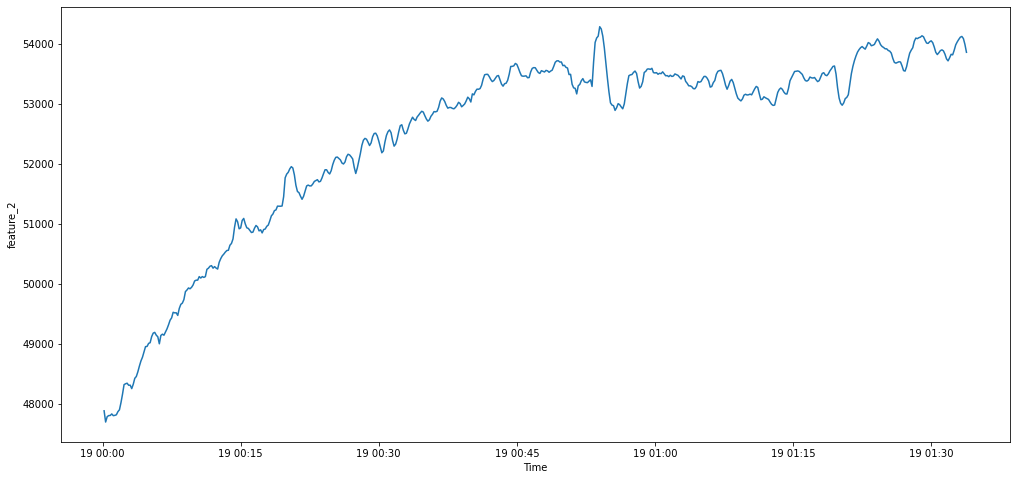

In [8]:
plt.figure(figsize=(17, 8))
plt.plot(data.feature_2)
plt.ylabel('feature_2')
plt.xlabel('Time')
plt.grid(False)
plt.show()

### Moving average

In [9]:
def plot_moving_average(series, window):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')       
#     plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

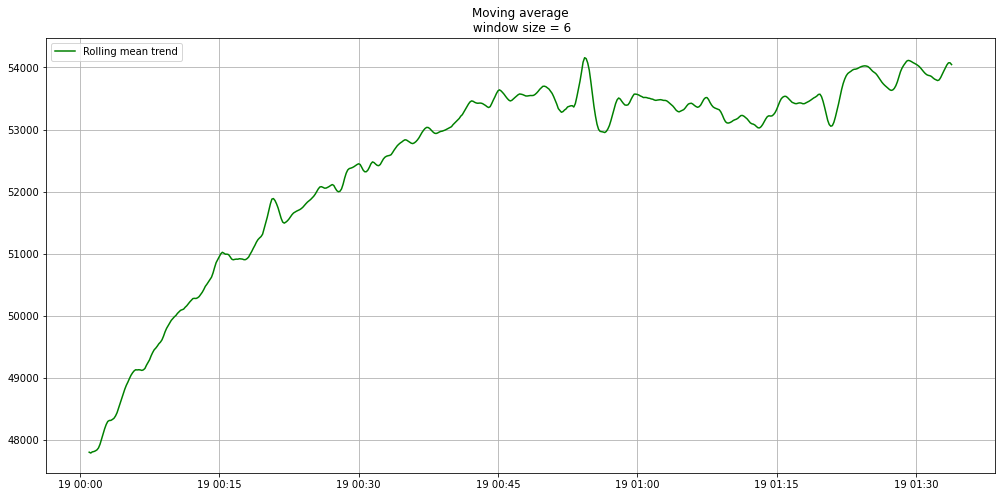

In [10]:
plot_moving_average(data.feature_2,6)

## Decomp to understand Seasonality

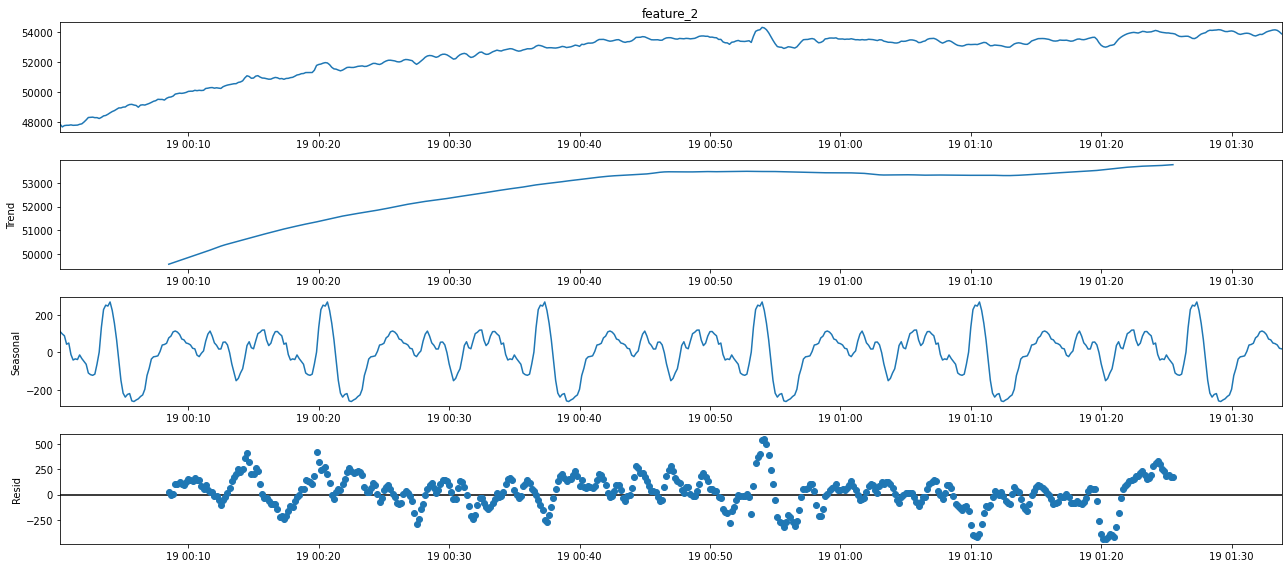

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data.feature_2, model='additive', period=100)
fig = decomposition.plot()
plt.show()

Quenstion needs answering

With increase in seasonality there is an increase in residuals also... so there can be increasing seasonality doesnt reduce reseduals... this seasonality is being extracted at the cost of residual ?

## Stationarity 

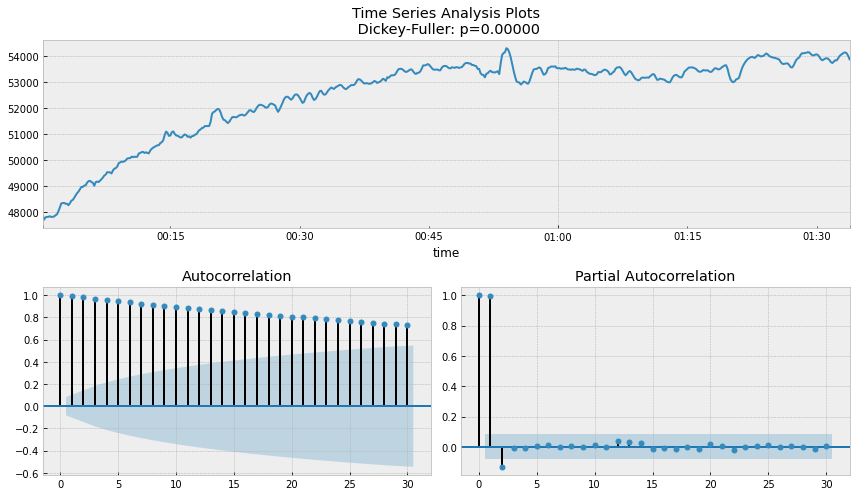

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.feature_2, lags=30)

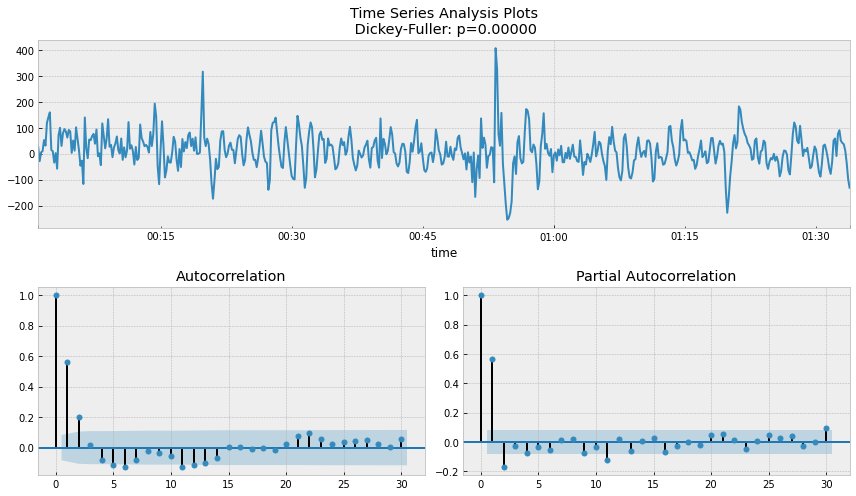

In [13]:
data_diff = data.feature_2 - data.feature_2.shift(1)

tsplot(data_diff[5:], lags=30)

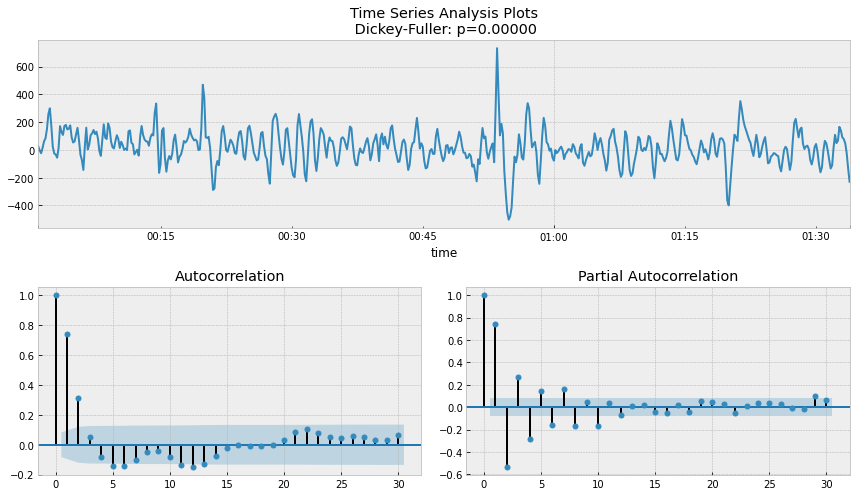

In [14]:
data_diff = data.feature_2 - data.feature_2.shift(2)

tsplot(data_diff[5:], lags=30)

### Predicted readings from the ACF and PACF graphs

* p-val = 0-2
* d = 1 or 2
* q = 0-2

# 2. ARIMA

In [15]:
from statsmodels.tsa.arima_model import ARIMA

In [16]:
#Set initial values and some bounds
ps = range(0, 1+1)
d = range(1,2+1)
qs = range(0, 2+1)

#Create a list with all possible combinations of parameters
parameters = product(ps, d, qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [17]:
def optimize_ARIMA(parameters_list):
    
    results = []
    best_aic = float('inf')
    
    for p in parameters_list:
        try: model = ARIMA(data.feature_2, order=(p[0],p[1],p[2]),freq='10S').fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        print(aic)
        
        #Save best model, AIC and peters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_p = p
        results.append([p, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_ARIMA(parameters_list)

6361.312133082529
6171.50377701899
6151.04025058831
6281.743901707521
6274.656697763396
6162.479894006567
6158.366954607596
6147.327454542037
6148.988902220457
6278.810063338749
6152.016939279089
6140.487136629914


In [18]:
result_table

,parameters,aic
0,"(1, 2, 2)",6140.487137
1,"(1, 1, 1)",6147.327455
2,"(1, 1, 2)",6148.988902
3,"(0, 1, 2)",6151.040251
4,"(1, 2, 1)",6152.016939
5,"(1, 1, 0)",6158.366955
6,"(0, 2, 2)",6162.479894
7,"(0, 1, 1)",6171.503777
8,"(0, 2, 1)",6274.656698
9,"(1, 2, 0)",6278.810063


In [19]:
p,d, q = result_table.parameters[0]

best_model = ARIMA(data.feature_2, order=(p, d, q)).fit(disp=-1)

print(best_model.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.feature_2   No. Observations:                  561
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -3065.244
Method:                       css-mle   S.D. of innovations             56.838
Date:                Fri, 17 Jul 2020   AIC                           6140.487
Time:                        17:27:56   BIC                           6162.136
Sample:                    03-19-2019   HQIC                          6148.940
                         - 03-19-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0587      0.030     -1.976      0.048      -0.117      -0.000
ar.L1.D2.feature_2     0.3732      0.068      5.506      0.000       0.240       0.506
ma.L1.D2.feature_2  

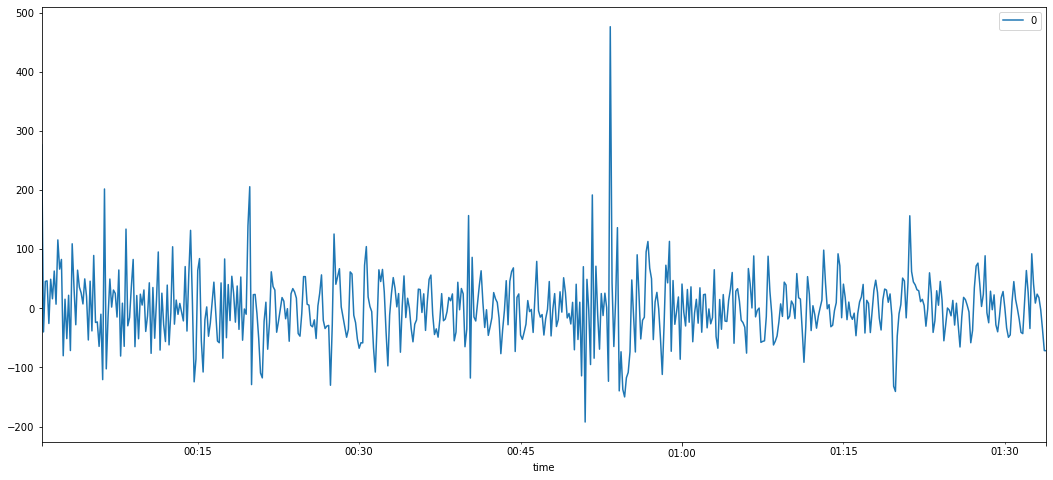

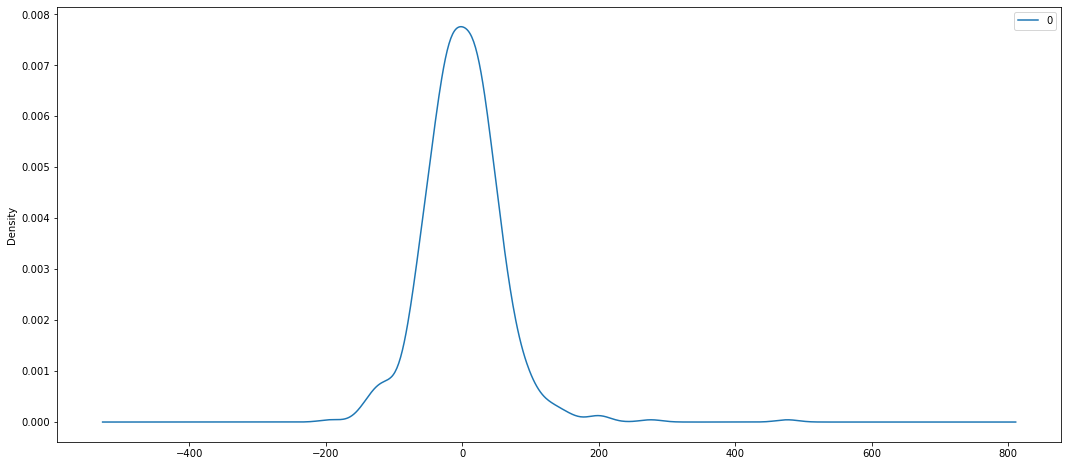

                0
count  561.000000
mean     0.779823
std     57.422287
min   -192.405605
25%    -31.987486
50%     -0.933103
75%     30.899059
max    476.464949


In [20]:
# ploting residual errors
residuals = pd.DataFrame(best_model.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

### Conclusion for ARIMA

* No trend is observed in residuals plot
* It shows a good sort of normality, it has peakesness, and base is a little wanky, but!!
* It 

Conclusion : There is no problem with the ARIMA model, but on the public score, I got a bad RMSE. 
There is a limitations in using ARIMA as a predictor model. 

### NOTE : 
PS : With the outlier my ARIMA model was getting the AIC scores in the 8000s

Just removing the first Data point lead my AIC score down to 6000s 

# 3. Making Prediction using mean of last 10 data points 

In [21]:
old = list(data['feature_2'].values)
len(old)

563

In [22]:
def make_pred(array=old, steps=375, window=10):
    l=len(array)
    for i in range(1,steps+1):
        pos=len(array)
        sum=0
        for j in range(pos-window,pos):
            sum = sum + array[j]
        array.append(sum/window)
    return array

In [23]:
new = make_pred(old,375)
new=new[563:]

In [24]:
sol = pd.DataFrame()
sol['feature_2'] = new
sol.index =[i for i in range(564,(564+375))]
sol.index.name = 'id'
sol.to_csv("Sol_10mean.csv")

### Conclusion for this model 
I am getting a score of 600 with simple MA


I am pretty With Auto regression component & proper singularity we can achieve much better results

# 4. Solving using fbprohet

### I decided to read up online, on good time-series models

Things we were aware of : 
1. Primary challenege in ARIMA(p,d,q) is to determine p,d,q accuaretly. 
2. We can see there is no seasonality.
3. I have got a score of ~600 (rmse) by using simple MA (10 days), tuning it for other lags would result in a slightly better score!
4. Moreover, It can be drastically improved by including a Auto Regression component. 
5. For auto regression we need to get staionarity, removing of trend from the graph. 
5. From suggestions online, I have decided to go ahead with building an fbprophet model, as it is a self staionrizing model. plus p,d,q value is predicted by the package and incase I have made an error there, It will be highlighted. 


### Speculation that caused me to check fbprophet

Before I go ahead I need to add another speculation, I am again not entirely sure of this, need to check this. I am speculating that the ARIMA model can remove trend only whent the trend is linear, since "I" component of ARIMA used an diffentiating component 'd'

Again this need to be checked and if anyone knows the answers please feel free to comment. I am going to dive into the depth of derivation of ARIMA to determine if I am true on not. Understand how the model tranforms the data to stationarity. 

I am 100% sure that autoregression has the same limitations as linear modeling 

PS:
Stationarity doesnt only mean removing the trend, it also means removing co-varience and homeoskedacity..etc 

In [25]:
from fbprophet import Prophet

In [26]:
#facebook has it's own outlier dection so I will not delete the first data 
data = pd.read_csv(DATAPATH, index_col=['time'], parse_dates=['time'])

In [27]:
data_fb = data[['feature_2']].reset_index()
data_fb.columns = ['ds','y']
data_fb

,ds,y
0,2019-03-19 00:00:00,54479.540513
1,2019-03-19 00:00:10,47888.033714
2,2019-03-19 00:00:20,47700.882325
3,2019-03-19 00:00:30,47790.094648
4,2019-03-19 00:00:40,47808.402381
...,...,...
559,2019-03-19 01:33:10,54115.388787
560,2019-03-19 01:33:20,54127.830664
561,2019-03-19 01:33:30,54092.561194
562,2019-03-19 01:33:40,53994.714950


In [28]:
model = Prophet()
model.fit(data_fb)

test = model.make_future_dataframe(periods=375, freq='10S')
pred = model.predict(test)
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-03-19 00:00:00,48316.201386,47920.978703,48704.974317,48316.201386,48316.201386,0.0,0.0,0.0,0.0,0.0,0.0,48316.201386
1,2019-03-19 00:00:10,48325.383761,47902.335003,48727.677631,48325.383761,48325.383761,0.0,0.0,0.0,0.0,0.0,0.0,48325.383761
2,2019-03-19 00:00:20,48334.566136,47932.713260,48732.613383,48334.566136,48334.566136,0.0,0.0,0.0,0.0,0.0,0.0,48334.566136
3,2019-03-19 00:00:30,48343.748511,47938.912665,48753.057750,48343.748511,48343.748511,0.0,0.0,0.0,0.0,0.0,0.0,48343.748511
4,2019-03-19 00:00:40,48352.930886,47944.476571,48790.149761,48352.930886,48352.930886,0.0,0.0,0.0,0.0,0.0,0.0,48352.930886


In [29]:
#read full documentation carefully
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '900 seconds')
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-03-19 00:49:00,53712.735935,53281.220166,54178.413656,53627.163385,2019-03-19 00:48:50
1,2019-03-19 00:49:10,53722.772946,53257.334739,54184.441836,53697.032332,2019-03-19 00:48:50
2,2019-03-19 00:49:20,53732.809957,53245.107488,54176.634555,53720.394340,2019-03-19 00:48:50
3,2019-03-19 00:49:30,53742.846967,53278.426247,54214.790423,53722.572521,2019-03-19 00:48:50
4,2019-03-19 00:49:40,53752.883978,53278.886134,54213.582235,53700.932526,2019-03-19 00:48:50


We can observe a very low difference, between y and yhat

In [30]:
old = pred[:564].set_index('ds') #change to 563 for outlier correction
check = pd.concat([data['feature_2'],old['yhat']],axis=1)
check

,feature_2,yhat
2019-03-19 00:00:00,54479.540513,48316.201386
2019-03-19 00:00:10,47888.033714,48325.383761
2019-03-19 00:00:20,47700.882325,48334.566136
2019-03-19 00:00:30,47790.094648,48343.748511
2019-03-19 00:00:40,47808.402381,48352.930886
...,...,...
2019-03-19 01:33:10,54115.388787,54077.432328
2019-03-19 01:33:20,54127.830664,54084.218611
2019-03-19 01:33:30,54092.561194,54091.004894
2019-03-19 01:33:40,53994.714950,54097.791177


#### On seen data the RMSE :

In [31]:
mean_squared_error(check['feature_2'],check['yhat'])**.5

322.5491010114546

In [32]:
# #since I had removed the 1st data in the account of being an outlier, I have to now add one digit to the id
# pred['id'] = pred.index +1
# pred.set_index('id',inplace=True)

In [33]:
solution_fb=pred[564:]['yhat'] #change to 563 for outlier correction
solution_fb = pd.DataFrame(solution_fb) 
solution_fb.index.name = 'id'
solution_fb.columns = ['feature_2']
solution_fb.to_csv("Solution_fb.csv")

### Conclusion of fbprophet
Now that fbprohet model leads to an RMSE score of 900s in the public set. I am not sure time series is that effective


### Thoughts on what to do next 

time series has its limitations as SARIMAX AIC score was 4000 and lead to a public (rmse) score of 1600s, ARIMA AIC score was 6000 and did not have yield better results. Compared to SARIMAX the AIC is higher, and we can see from the residual graphs that it is a well fit model.  Even fbprohet failed to get a score better than 900s. 

I am speculating, but asuming that these models can only pick up linear trends and cannot handle logarithmic trend. But then again I have spoken about this in the notebok too as I explain my observations.

[Only easy way to confirm is I can fit time/id and feature_2 into a linear model and predict values, if it yields results close to the prediction my speculations would be correct. But again due to limitations of time and the number of tests, I decided to indulge into it later.]

Coming back, I am Concluding that AR cannot predict the logarithmic relation, so I decided to use a logarithmic transformation and use LR to predict it myself.


# 5. Using Logarithmic fit on the data as it resembles a logarithmic graph

## log and a linear regression

In [34]:
DATAPATH = '/kaggle/input/into-the-future/train.csv' 

data = pd.read_csv(DATAPATH, index_col=['time'], parse_dates=['time'])
data.head(10)

,id,feature_1,feature_2
time,,,
2019-03-19 00:00:00,0,735.740043,54479.540513
2019-03-19 00:00:10,1,734.102947,47888.033714
2019-03-19 00:00:20,2,730.060336,47700.882325
2019-03-19 00:00:30,3,725.609742,47790.094648
2019-03-19 00:00:40,4,724.328480,47808.402381
2019-03-19 00:00:50,5,723.715893,47810.517411
2019-03-19 00:01:00,6,720.406875,47835.758121
2019-03-19 00:01:10,7,712.682269,47806.938481
2019-03-19 00:01:20,8,711.509741,47812.099044


In [35]:
log_check = data[['id','feature_2']]
log_check = log_check[1:]

In [36]:
log_check['id_log'] = np.log1p(log_check.id)

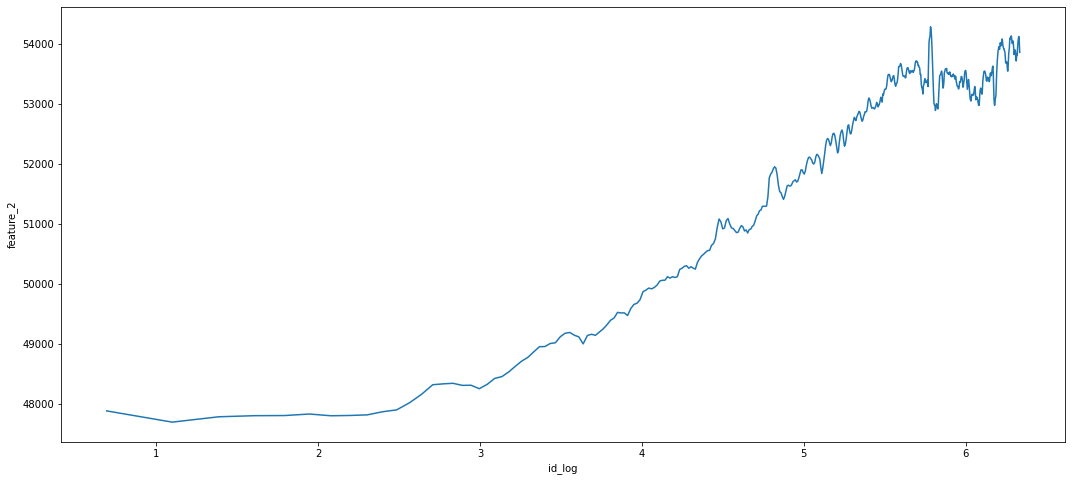

In [37]:
sns.lineplot(data = log_check, x='id_log',y='feature_2')

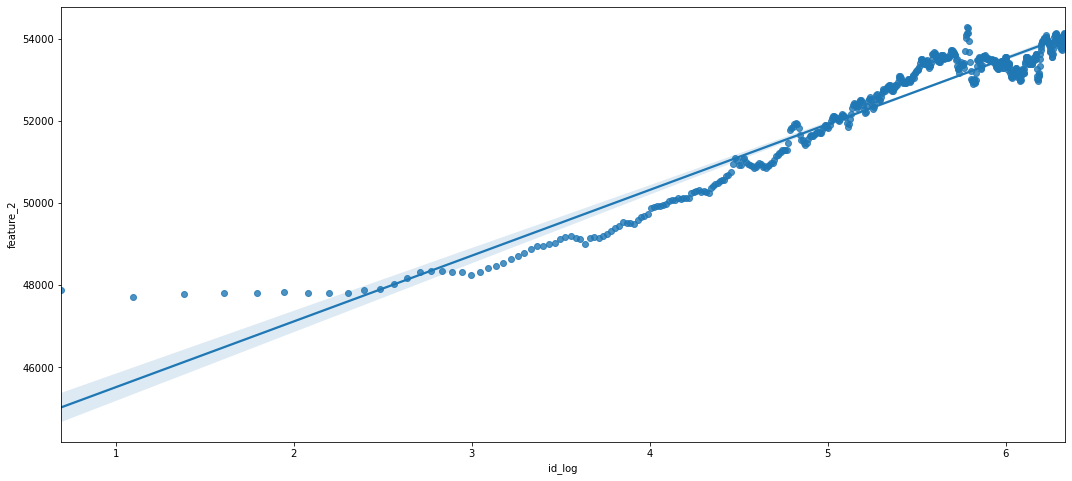

In [38]:
sns.regplot(data = log_check, x='id_log',y='feature_2')

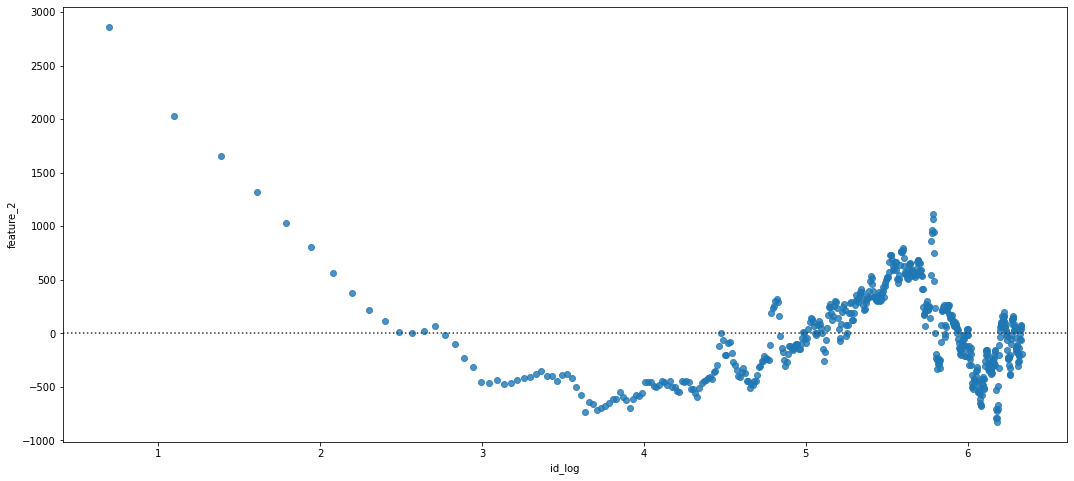

In [39]:
sns.residplot(data = log_check, x='id_log',y='feature_2')

Doesnt look like a good linear plot after log check, but lets try

### The plan is to get a linear prediction after logrithmic transfromation, then find the difference between the prediction and the actual value, and check for seasonality ! If there is Seasonality 

In [40]:
log_check

,id,feature_2,id_log
time,,,
2019-03-19 00:00:10,1,47888.033714,0.693147
2019-03-19 00:00:20,2,47700.882325,1.098612
2019-03-19 00:00:30,3,47790.094648,1.386294
2019-03-19 00:00:40,4,47808.402381,1.609438
2019-03-19 00:00:50,5,47810.517411,1.791759
...,...,...,...
2019-03-19 01:33:10,559,54115.388787,6.327937
2019-03-19 01:33:20,560,54127.830664,6.329721
2019-03-19 01:33:30,561,54092.561194,6.331502


In [41]:
from sklearn.linear_model import LinearRegression

lr_log = LinearRegression()
lr_log.fit(log_check[['id_log']],log_check.feature_2)

print(mean_squared_error(log_check.feature_2,lr_log.predict(log_check[['id_log']]))**.5)

log_check['LogPredict']=lr_log.predict(log_check[['id_log']])
log_check['diff']=log_check['LogPredict']-log_check['feature_2']

418.05110085942994


In [42]:
log_check

,id,feature_2,id_log,LogPredict,diff
time,,,,,
2019-03-19 00:00:10,1,47888.033714,0.693147,45024.780647,-2863.253066
2019-03-19 00:00:20,2,47700.882325,1.098612,45673.984451,-2026.897874
2019-03-19 00:00:30,3,47790.094648,1.386294,46134.601880,-1655.492768
2019-03-19 00:00:40,4,47808.402381,1.609438,46491.884515,-1316.517866
2019-03-19 00:00:50,5,47810.517411,1.791759,46783.805683,-1026.711728
...,...,...,...,...,...
2019-03-19 01:33:10,559,54115.388787,6.327937,54046.831543,-68.557244
2019-03-19 01:33:20,560,54127.830664,6.329721,54049.688160,-78.142504
2019-03-19 01:33:30,561,54092.561194,6.331502,54052.539690,-40.021504


In [43]:
mean_absolute_error(log_check.feature_2,log_check.LogPredict)

327.047409610584

In [44]:
DATAPATH = '/kaggle/input/into-the-future/test.csv' 
test = pd.read_csv(DATAPATH, index_col=['time'], parse_dates=['time'])
test['id_log']=np.log1p(test.id)
test['feature_2']=lr_log.predict(test[['id_log']])
# test

In [45]:
test = test[['id','feature_2']]
test.set_index('id',inplace=True)
test.to_csv("Solution_logT.csv")

### Conclusion of the Log Tranform - LR Model 

This model leads to an RMSE score of 225s in the public set.  

# 6. Preparing a Validation set

I am thinking of a few radicle tests on the data that is why I am building my own validation set 

In [46]:
DATAPATH = '/kaggle/input/into-the-future/train.csv' 

data = pd.read_csv(DATAPATH, index_col=['time'], parse_dates=['time'])

In [47]:
from random import seed
from random import randint

valid_id = list()
seed(randint(1,10))
for i in range (0,90):
    valid_id.append(randint(1,540))

valid_id = list(set(valid_id))
valid_id.sort()

#note anyone running this notebook, my data will be different from yours, I have kept in mind to check the length of the valid_id set to be 15%(approx) of the total data 

In [48]:
TRAIN = data[~data['id'].isin(valid_id)]
VALID = data[data['id'].isin(valid_id)]

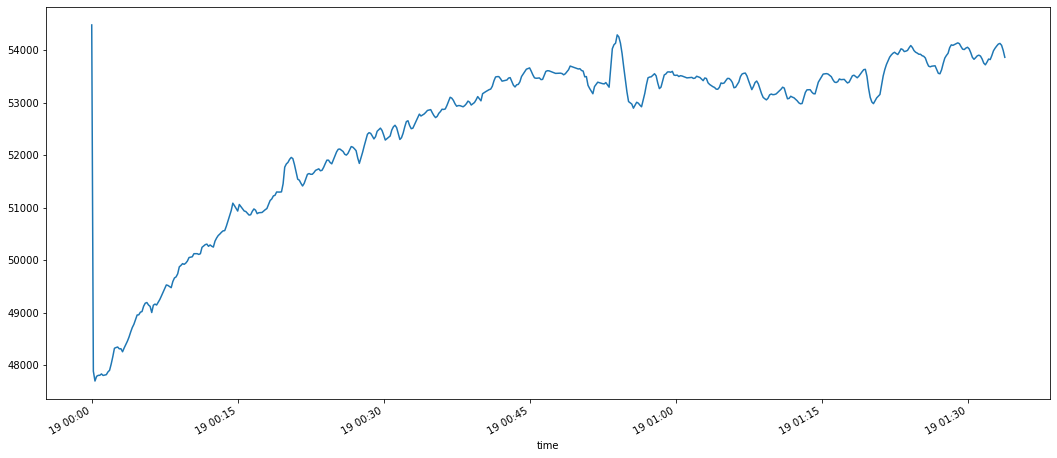

In [49]:
TRAIN.feature_2.plot()

the training set dosent seem to be affected a lot, thanks to the randomization, therefore I will save this data, since the seed is different, It can lead to any result when run again, and I dont want that

In [50]:
VALID.shape[0]+TRAIN.shape[0]

564

# 7. Using population data and assuming the polulation will be flattening the curve

As logarithmic curves tend to flatten in the end maybe I can just check the trend of the flattening part and assume the poluation data is flattening. 

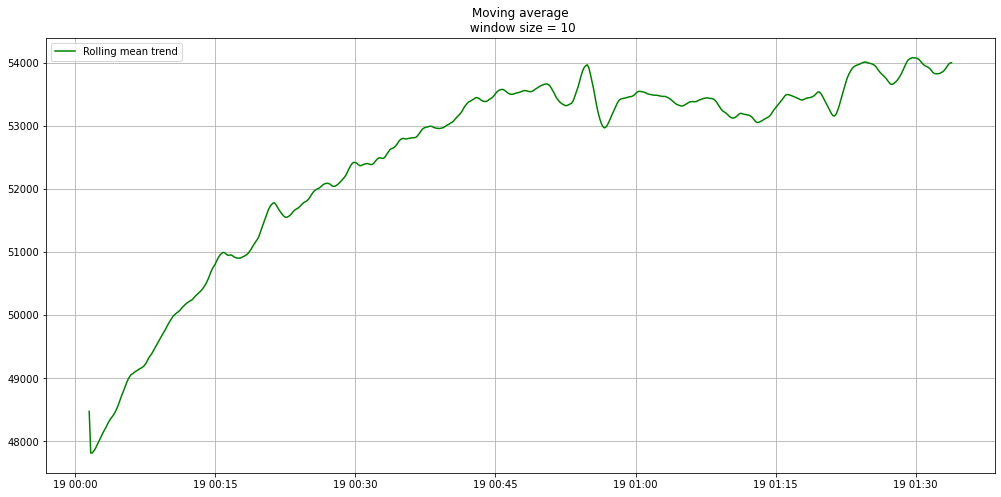

In [51]:
plot_moving_average(data.feature_2,10)

A deep dive inspection shows :
* Good slope that until the 47th minute 
* Post which we see a flattening trend but more undulations 
* Predicting the undulation might be difficult 
* But we can asume due to logarithmic curve it will be close to linearity

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


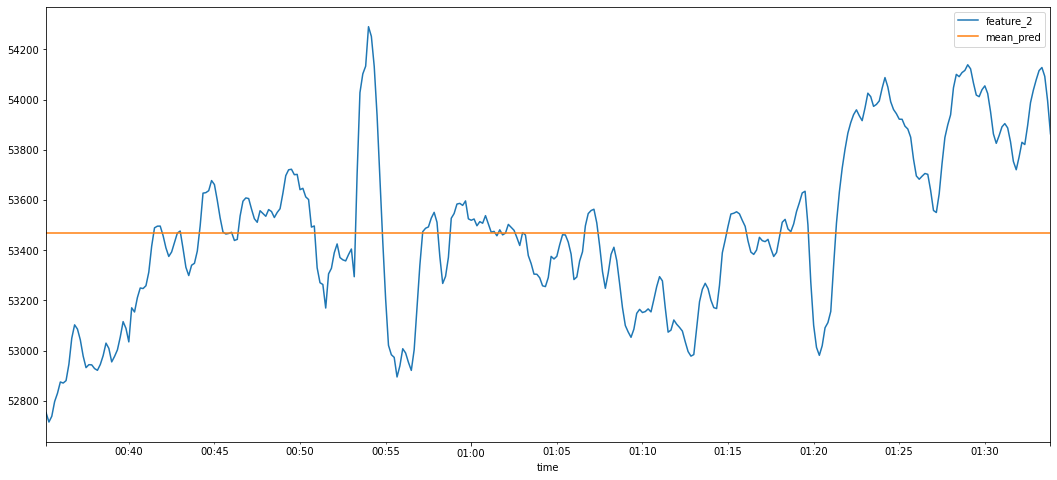

In [52]:
graph_2 = data[data.index > pd.to_datetime('2019-03-19 00:35:00')]
graph_2.feature_2.plot(legend=True)
graph_2['mean_pred']=graph_2.feature_2.mean() 
graph_2.mean_pred.plot(legend=True)
# graph_2['MA'] = graph_2.feature_2.rolling(window=30).mean()
# graph_2.MA.plot(legend=True)

I am thinking what if we use this as the predictor line! 

In [53]:
data

,id,feature_1,feature_2
time,,,
2019-03-19 00:00:00,0,735.740043,54479.540513
2019-03-19 00:00:10,1,734.102947,47888.033714
2019-03-19 00:00:20,2,730.060336,47700.882325
2019-03-19 00:00:30,3,725.609742,47790.094648
2019-03-19 00:00:40,4,724.328480,47808.402381
...,...,...,...
2019-03-19 01:33:10,559,423.726707,54115.388787
2019-03-19 01:33:20,560,424.278568,54127.830664
2019-03-19 01:33:30,561,420.127639,54092.561194


We can take this graph and predict a lienear trend and assume it will follow the linear trend, as there is no way of predicting the undulation/noise!

In [54]:
mean_squared_error(graph_2.feature_2,graph_2.mean_pred)**.5

328.6315985417041

Since even af the flatterning we can see a small amount of slope, I am planning to perform linear regresion and use that as a predictor

In [55]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(graph_2[['id']],graph_2.feature_2)

print(mean_squared_error(graph_2.feature_2,lr.predict(graph_2[['id']]))**.5)

graph_2['LinearPrediction']=lr.predict(graph_2[['id']])


275.7974886209033


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
graph_2.feature_2.mean()

53469.66023204289

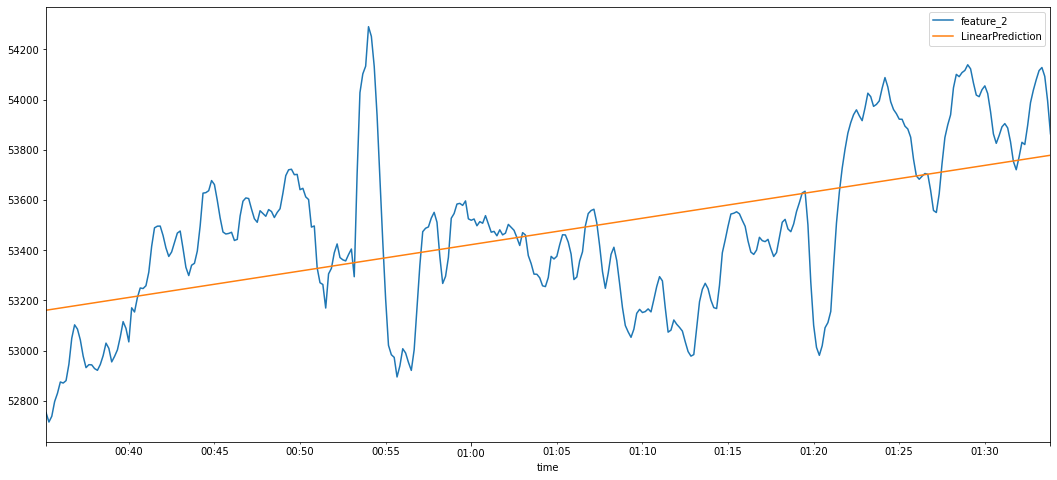

In [57]:
graph_2.feature_2.plot(legend=True)
graph_2.LinearPrediction.plot(legend=True)

In [58]:
DATAPATH = '/kaggle/input/into-the-future/test.csv' 
test = pd.read_csv(DATAPATH, index_col=['time'], parse_dates=['time'])
test['feature_2']=lr.predict(test[['id']])
test

,id,feature_1,feature_2
time,,,
2019-03-19 01:34:00,564,423.064004,53780.059581
2019-03-19 01:34:10,565,423.342749,53781.813250
2019-03-19 01:34:20,566,423.181186,53783.566919
2019-03-19 01:34:30,567,421.275243,53785.320587
2019-03-19 01:34:40,568,422.208444,53787.074256
...,...,...,...
2019-03-19 02:35:40,934,432.292203,54428.916978
2019-03-19 02:35:50,935,433.661272,54430.670647
2019-03-19 02:36:00,936,435.686429,54432.424316


In [59]:
test = test[['id','feature_2']]
test.set_index('id',inplace=True)
test.to_csv("Solution_LR_population.csv")

# 8. logT + LR + Sin

In [60]:
train = TRAIN.copy()
valid = VALID.copy()
train = train[1:]

In [61]:
train['id_log']=np.log1p(train['id'])

In [62]:
lr_log2 = LinearRegression()
lr_log2.fit(train[['id_log']],train['feature_2'].values)

y_hat = lr_log2.predict(train[['id_log']])
train['pred_f2'] = y_hat
train['diff'] = train['pred_f2']-train['feature_2']

In [63]:
mean_squared_error(train['feature_2'],train['pred_f2'])**0.5

417.88865627300737

In [64]:
train.reset_index() #redundent ??

,time,id,feature_1,feature_2,id_log,pred_f2,diff
0,2019-03-19 00:00:10,1,734.102947,47888.033714,0.693147,45080.719389,-2807.314325
1,2019-03-19 00:00:20,2,730.060336,47700.882325,1.098612,45724.300763,-1976.581563
2,2019-03-19 00:00:30,3,725.609742,47790.094648,1.386294,46180.929014,-1609.165634
3,2019-03-19 00:00:40,4,724.328480,47808.402381,1.609438,46535.117402,-1273.284978
4,2019-03-19 00:00:50,5,723.715893,47810.517411,1.791759,46824.510387,-986.007024
...,...,...,...,...,...,...,...
471,2019-03-19 01:33:10,559,423.726707,54115.388787,6.327937,54024.634806,-90.753980
472,2019-03-19 01:33:20,560,424.278568,54127.830664,6.329721,54027.466684,-100.363980
473,2019-03-19 01:33:30,561,420.127639,54092.561194,6.331502,54030.293518,-62.267676
474,2019-03-19 01:33:40,562,421.291993,53994.714950,6.333280,54033.115327,38.400376


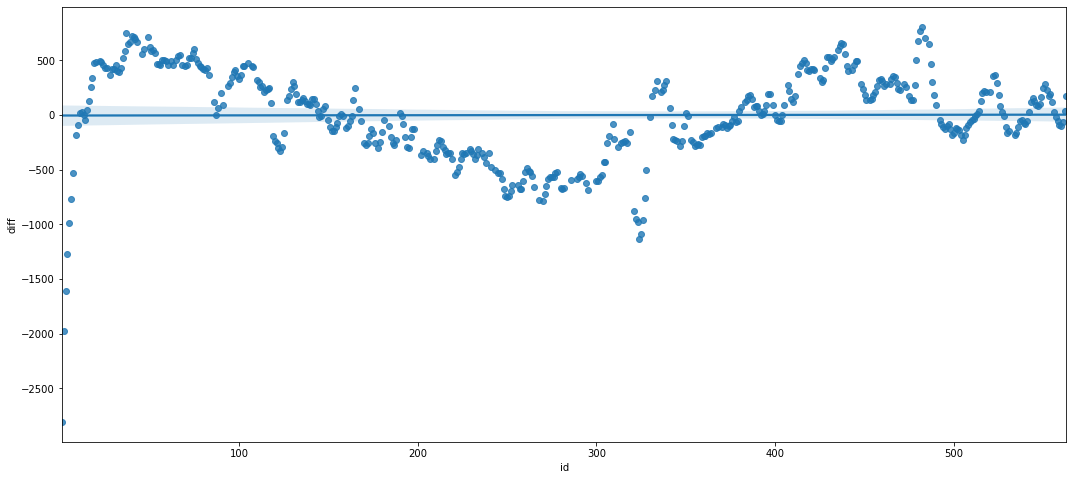

In [65]:
sns.regplot(data=train,x='id',y='diff')

In [66]:
train['diff'].mean()

-1.146421892991086e-12

This is not normal, sum of residuals is 0. This feels contrived

Moreover it looks like a sin curve kind of a graph, I am going to brute code it ! 

Just for Exploration sake : 

1. I will use some Random forest regressor to determine this !
1. I will use time series decomp. on this 

### Solving for the error

### A. Random Forest 

In [67]:
from sklearn.ensemble import RandomForestRegressor

rf_diff = RandomForestRegressor().fit(train[['id']],train['diff']) 
train['pred_diff_rf'] = rf_diff.predict(train[['id']])

In [68]:
print("RMSE of RF on Diff of Seen Data : {}".format(mean_squared_error(train['diff'],train['pred_diff_rf'])**0.5))

RMSE of RF on Diff of Seen Data : 25.05529066753569


#### Performing on Unseen data

In [69]:
#log-LR prediction
valid['id_log']=np.log1p(valid['id'])
valid['pred_f2'] = lr_log2.predict(valid[['id_log']])
#rf prediction
valid['pred_diff_rf'] = rf_diff.predict(valid[['id']])
valid['pred_f2_2nd_order_rf']=valid['pred_f2']+valid['pred_diff_rf'] #Mistake <- This will get clearer later! Just keep in mind. "Mistake!"

__Comparing the models__

In [70]:
print("RMSE of log-LR on feature_2 of 'UN-Seen' Data : {}".format(mean_squared_error(valid['feature_2'],valid['pred_f2'])**0.5))

RMSE of log-LR on feature_2 of 'UN-Seen' Data : 420.8585476677139


In [71]:
print("RMSE of log-LR + RF on feature_2 of 'UN-Seen' Data : {}".format(mean_squared_error(valid['feature_2'],valid['pred_f2_2nd_order_rf'])**0.5))

RMSE of log-LR + RF on feature_2 of 'UN-Seen' Data : 831.1442334294024


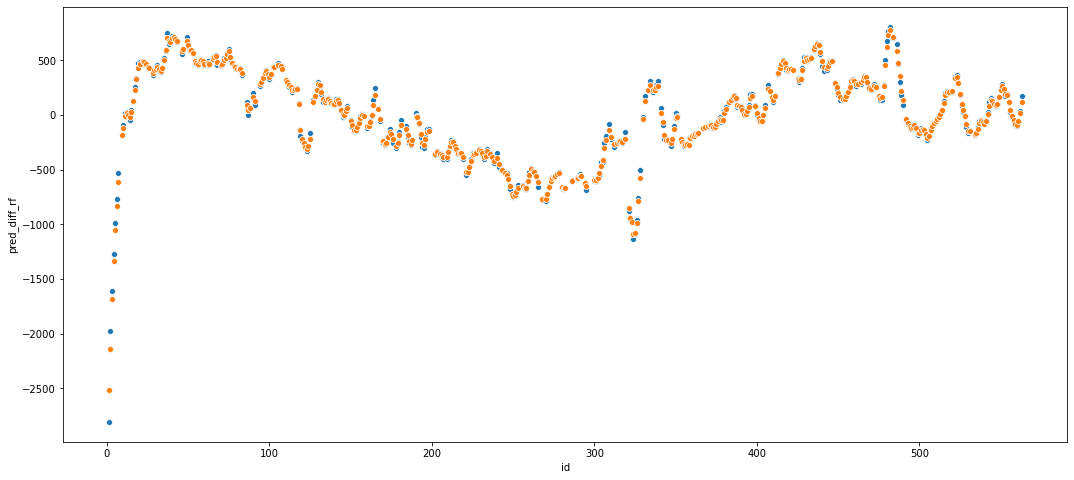

In [72]:
sns.scatterplot(data=train,x='id',y='diff')
sns.scatterplot(data=train,x='id',y='pred_diff_rf')

I think I have gone into unchartered terretory (by me) ! 

See for seen data this regressor makes prediction like high accuracy(rmse) we can see in the graph, but when it comes to unseen data poof! 
My speculation :
I think the data points are low in number for random forest!

I have chosen the wrong model.. That is all !

### B. Time series decomposition

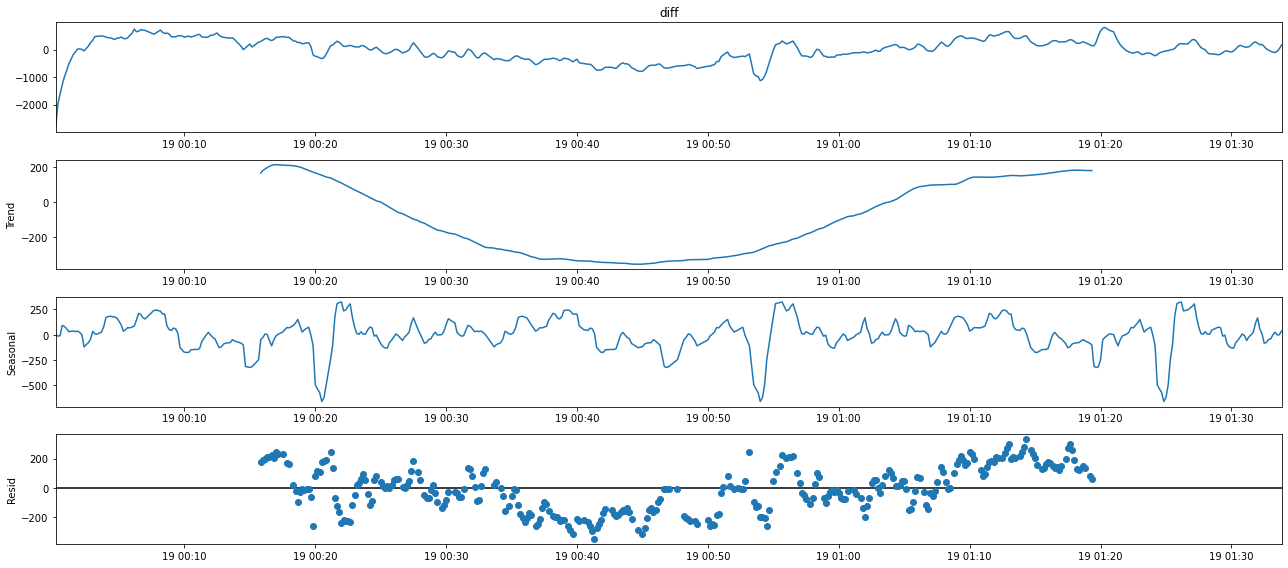

In [73]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(train['diff'], model='additive', period=160)
fig = decomposition.plot()
plt.show()

nope this is not it 

#### C. Sinusoidal ?

In [74]:
def sinusoid(x,A,offset,omega,phase):
 return A*np.sin(omega*x+phase) + offset

T = 300
def get_p0(x, y):
 
 A0 = (max(y[0:T]) - min(y[0:T]))/2
 offset0 = y[0]
 phase0 = 0
 omega0 = 2.*np.pi/T
 return [A0, offset0,omega0, phase0]

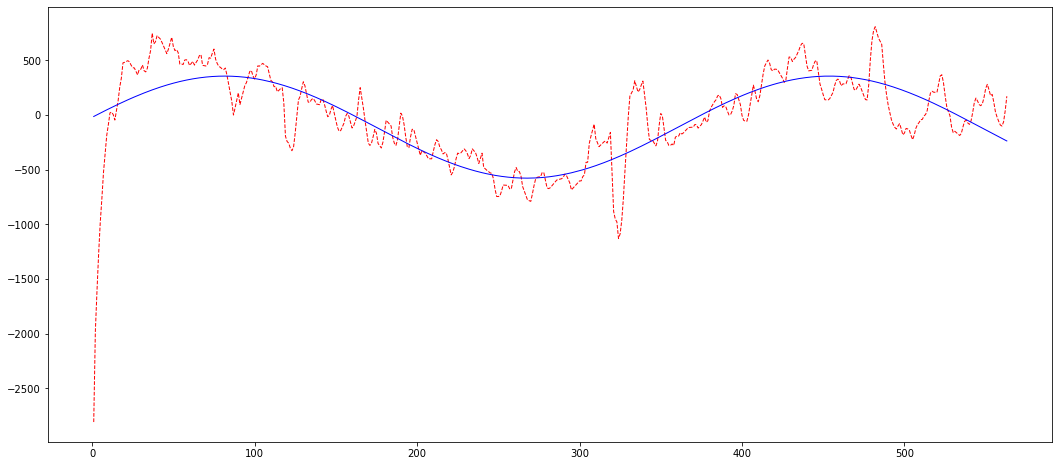

In [75]:
from scipy.optimize import curve_fit

X = train['id']
y = train['diff']

import math
param, covariance = curve_fit(sinusoid, X, y, p0=get_p0(X,y))
plt.plot(X, y, color='red', linewidth=1,linestyle='dashed')
plt.plot(X, sinusoid(X, *param), color='blue', linewidth=1)
plt.show()

OHHH HOLLLYY !!!

### $diff = sin(Omega*id)$

How to use this ? 

__When the target variable(feature_2) is a logarithmic distribution:__

I log transformed the id so that the feature_2 is linearly related to the new value (id_log)



__When the target variable(feature_2) is a logarithmic distribution:__

here I sin transform the id so that the difference is leanearly related to the new value (id_sin)

In [76]:
train.drop('pred_diff',inplace=True,axis=1)

KeyError: "['pred_diff'] not found in axis"

In [77]:
X = train['id']
y = train['diff']

param, covariance = curve_fit(sinusoid, X, y, p0=get_p0(X,y))
train['pred_diff'] = sinusoid(X, *param)

In [78]:
train['pred_diff_2nd_oreder_sin']=train['feature_2']+train['pred_diff']

In [79]:
mean_squared_error(train['feature_2'],train['pred_diff_2nd_oreder_sin'])**0.5

305.2719932115524

305 is a drastic drop from 417 that we observed by RMSE, on seen data, by only using Log-LR



__We check on Validation Set__

In [80]:
valid.drop('pred_f2_2nd_order_rf',axis=1,inplace=True)
valid.drop('pred_diff',axis=1,inplace=True)

KeyError: "['pred_diff'] not found in axis"

In [81]:
#on unseen data, see we train the model on tain data, predict using 

X = train['id']
y = train['diff']

param, covariance = curve_fit(sinusoid, X, y, p0=get_p0(X,y)) #training
valid['pred_diff'] = sinusoid(valid['id'], *param) # predicting

In [82]:
valid['pred_diff_2nd_order_sin']=valid['pred_f2']-valid['pred_diff']

In [83]:
mean_squared_error(valid['feature_2'],valid['pred_diff_2nd_order_sin'])**0.5

196.6414513732131

In [84]:
valid['diff']=valid['pred_f2']-valid['feature_2']

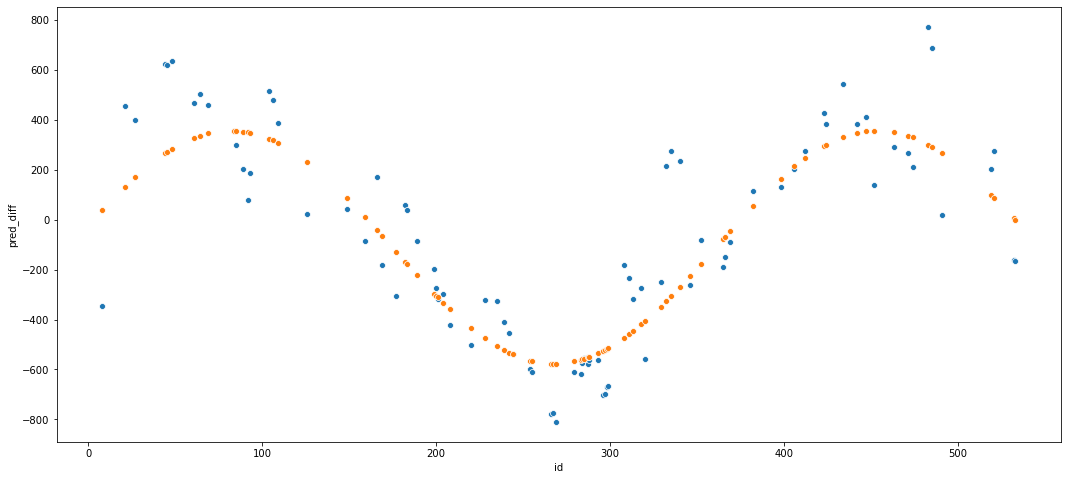

In [85]:
sns.scatterplot(data=valid,x='id',y='diff',legend='brief')
sns.scatterplot(data=valid,x='id',y='pred_diff',legend='full')

#idk why there are no legends I am tired, so I will forgo this for now. I can understand the data... I am just happy to be able get rmse of 200 here... :)

### I just realized I made a "Mistake" I '+' the difference term for thr random forest model and went on!! SHHHIIII***

In [86]:
valid['pred_diff_rf'] = rf_diff.predict(valid[['id']])
valid['pred_f2_2nd_order_rf']=valid['pred_f2'] - valid['pred_diff_rf'] #Mistake <- This will get clearer later! Just keep in mind. "Mistake!"

In [87]:
mean_squared_error(valid['feature_2'],valid['pred_f2_2nd_order_rf'])**0.5

59.00950332305501

Woaaaaaaahhhhh.... !! 
RMSE : 55

Wait this is over fitting, I just checked the graph of the actual 'diff' vs the 'predicted diff' (shown above)

anyways, I will use both the models to test and we will test model no. 7 tomorrow morning on the public test data!

### Public Test Data 

In [88]:
#data from the log model
log_check.head()

,id,feature_2,id_log,LogPredict,diff
time,,,,,
2019-03-19 00:00:10,1,47888.033714,0.693147,45024.780647,-2863.253066
2019-03-19 00:00:20,2,47700.882325,1.098612,45673.984451,-2026.897874
2019-03-19 00:00:30,3,47790.094648,1.386294,46134.601880,-1655.492768
2019-03-19 00:00:40,4,47808.402381,1.609438,46491.884515,-1316.517866
2019-03-19 00:00:50,5,47810.517411,1.791759,46783.805683,-1026.711728


#### Sin Model

In [89]:
#id : 564-938
sol = pd.DataFrame()
sol['id']= [i for i in range(564,939)]
sol['id_log']= np.log1p(sol['id'])


#Sin predictor of the difference
X = log_check['id']
y = log_check['diff']
param, covariance = curve_fit(sinusoid, X, y, p0=get_p0(X,y)) #training


#finally
sol['feature_2']= lr_log.predict(sol[['id_log']]) - sinusoid(sol['id'], *param) 

In [90]:
sol = sol[['id','feature_2']]
sol.set_index('id',inplace=True)
sol.to_csv("solution_log_sin.csv")

#### RF model

In [91]:
#id : 564-938
sol = pd.DataFrame()
sol['id']= [i for i in range(564,939)]
sol['id_log']= np.log1p(sol['id'])


#RF predictor of the difference
rf_diff = RandomForestRegressor().fit(log_check[['id']],log_check['diff']) 


#finally
sol['feature_2']= lr_log.predict(sol[['id_log']]) - rf_diff.predict(sol[['id']]) 

In [92]:
sol = sol[['id','feature_2']]
sol.set_index('id',inplace=True)
sol.to_csv("solution_log_RF.csv")

### Conclusion Left

Unexpected, I was expecting better results
* 243 : score on Log + LR + RF
* 475 : score on Log + LR + Sin 

In [93]:
log_check['ans']= log_check['LogPredict'] - sinusoid(log_check['id'], *param)
log_check['sin_diff']=sinusoid(log_check['id'], *param)

## REFRENCES

Time Series (general)

* https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
* https://towardsdatascience.com/the-basics-time-series-and-seasonal-decomposition-b39fef4aa976
* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
* https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q **[Best material to understand stationarity]**



For fbprophet

* https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet
* https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

For Sinusoidal Graph

* https://towardsdatascience.com/how-to-predict-a-variable-sinusoid-in-python-4a21404dc061